# Model 1

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import scipy
import datetime

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV
from skmultilearn.model_selection import iterative_train_test_split, IterativeStratification
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
# from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from skmultilearn.problem_transform import LabelPowerset
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.adapt import MLkNN
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score, hamming_loss, ConfusionMatrixDisplay, confusion_matrix, multilabel_confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding, GlobalMaxPool1D
from tensorflow.keras.metrics import Precision, Recall, Accuracy, PrecisionAtRecall, AUC

# from sklearnex import patch_sklearn
# patch_sklearn()

In [33]:
# Read in the pickle file

with open('../pickled_models/after_eda.pickle', 'rb') as f:
    df_train = pickle.load(f)

df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic,word_count,unique_word_count,upper_case_word_count,stop_word_count,punctuation_count,title_word_count,sentence_count,percent_unique_word_count,percent_upper_case_word_count,percent_punctuation_count,cleaned_comment_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,43,41,2,20,10,11,5,95.348837,4.651163,23.255814,explanation why the edit make under username h...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,17,17,1,3,12,3,4,100.000000,5.882353,70.588235,aww match this background colour seemingly sti...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,42,39,0,21,6,2,4,92.857143,0.000000,14.285714,hey man really not try edit war just that this...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,113,82,5,58,21,7,6,72.566372,4.424779,18.584071,more cannot make any real suggestions improvem...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,13,13,0,6,5,2,3,100.000000,0.000000,38.461538,you sir hero any chance you remember what page...


# Train test split

In [34]:
# Taking a subset of the data for faster processing

# df_train = df_train.sample(1000, random_state=42)

In [41]:
# train test split

features = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

X = df_train["cleaned_comment_text"].to_numpy()
y = df_train[features].to_numpy()

# X_train, y_train, X_test, y_test = iterative_train_test_split(
#     X.values.reshape(-1, 1), y.values, test_size=0.3,
# )

msss = MultilabelStratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=42)

for train_index, test_index in msss.split(X, y):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]

TRAIN: [     0      1      3 ... 159567 159568 159570] TEST: [     2      5      8 ... 159556 159562 159569]
TRAIN: [     0      1      2 ... 159567 159569 159570] TEST: [     3      4     10 ... 159559 159565 159568]


In [43]:
display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(111699,)

(111699, 6)

(47872,)

(47872, 6)

# scikit-learn estimators that have multi-learning support built-in


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
pipe_n = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95)),
    ('nn', KNeighborsClassifier(n_neighbors=3, n_jobs=-1)),
])

In [ ]:
pipe_n.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('nn', KNeighborsClassifier(n_jobs=-1, n_neighbors=3))])

In [ ]:
y_pred = pipe_n.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.9034926470588235

0.3694806215348379

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
pipe_rf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95)),
    ('rf', RandomForestClassifier(random_state=42, max_depth=5, n_jobs=-1, class_weight='balanced')),
])

In [ ]:
pipe_rf.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        n_jobs=-1, random_state=42))])

In [ ]:
y_pred = pipe_rf.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.00027155748663101604

0.12319412825100758

# One vs rest classifier

This classifier can also be used for multilabel classification.

In [41]:
pipe_log = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95)),
    ('log', OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=10_000), n_jobs=-1, )),
])

pipe_log.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('log',
                 OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                  max_iter=10000),
                                     n_jobs=-1))])

In [42]:
y_pred = pipe_log.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.874456885026738

0.6915746891123729

In [43]:
pipe_nb = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95)),
    ('mnb', OneVsRestClassifier(MultinomialNB(), n_jobs=-1)),
])

pipe_nb.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('mnb',
                 OneVsRestClassifier(estimator=MultinomialNB(), n_jobs=-1))])

In [44]:
y_pred = pipe_nb.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.903555314171123

0.37037938011539645

In [45]:
# Pipeline

pipe_svc = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95)),
    ('svc', OneVsRestClassifier(LinearSVC(class_weight='balanced', max_iter=10_000))),
])

In [46]:
pipe_svc.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('svc',
                 OneVsRestClassifier(estimator=LinearSVC(class_weight='balanced',
                                                         max_iter=10000)))])

In [48]:
y_pred = pipe_svc.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.8818098262032086

0.6911559534288386

In [60]:
multilabel_confusion_matrix(y_test, y_pred)

array([[[43250,    34],
        [ 3090,  1498]],

       [[47393,     0],
        [  479,     0]],

       [[45321,    16],
        [ 1884,   651]],

       [[47729,     0],
        [  143,     0]],

       [[45473,    36],
        [ 2006,   357]],

       [[47450,     0],
        [  422,     0]]])

# Multioutput classifier

In [50]:
pipe_log = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95)),
    ('log', MultiOutputClassifier(LogisticRegression(class_weight='balanced', max_iter=10_000, n_jobs=-1))),
])

pipe_log.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('log',
                 MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                    max_iter=10000,
                                                                    n_jobs=-1)))])

In [51]:
y_pred = pipe_log.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.874456885026738

0.6915746891123729

In [53]:
pipe_nb = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95)),
    ('log', MultiOutputClassifier(MultinomialNB())),
])

pipe_nb.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('log', MultiOutputClassifier(estimator=MultinomialNB()))])

In [54]:
y_pred = pipe_nb.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.903555314171123

0.37037938011539645

In [55]:
pipe_svc = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95)),
    ('log', MultiOutputClassifier(LinearSVC(class_weight='balanced', max_iter=10_000))),
])

pipe_svc.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('log',
                 MultiOutputClassifier(estimator=LinearSVC(class_weight='balanced',
                                                           max_iter=10000)))])

In [56]:
y_pred = pipe_svc.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.8818098262032086

0.6911559534288386

# ClassifierChain

In [17]:
pipe_log = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95,max_features=3000)),
    ('log', ClassifierChain(LogisticRegression(class_weight='balanced', max_iter=10_000, n_jobs=-1))),
])

pipe_log.fit(X_train.ravel(), y_train)

KeyboardInterrupt: 

In [60]:
y_pred = pipe_log.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.862863469251337

0.6139030550824732

In [61]:
pipe_nb = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95)),
    ('log', ClassifierChain(MultinomialNB())),
])

pipe_nb.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('log', ClassifierChain(base_estimator=MultinomialNB()))])

In [62]:
y_pred = pipe_nb.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.9095086898395722

0.4871984457196693

In [63]:
pipe_svc = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95)),
    ('log', ClassifierChain(LinearSVC(class_weight='balanced', max_iter=10_000))),
])

pipe_svc.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('log',
                 ClassifierChain(base_estimator=LinearSVC(class_weight='balanced',
                                                          max_iter=10000)))])

In [64]:
y_pred = pipe_svc.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.8839613970588235

0.6748073526295787

# Trying out the adapted algorithm

## Label Powerset

In [6]:
pipe_log = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95, max_features=3000)),
    ('log', LabelPowerset(LogisticRegression(class_weight='balanced', max_iter=10_000))),
])

pipe_log.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, max_features=3000, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('log',
                 LabelPowerset(classifier=LogisticRegression(class_weight='balanced',
                                                             max_iter=10000),
                               require_dense=[True, True]))])

In [8]:
y_pred = pipe_log.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.7514622326203209

0.47729799265999495

In [8]:
pipe_nb = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95, max_features=3000)),
    ('log', LabelPowerset(MultinomialNB())),
])

pipe_nb.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, max_features=3000, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('log',
                 LabelPowerset(classifier=MultinomialNB(),
                               require_dense=[True, True]))])

In [9]:
y_pred = pipe_nb.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.9106366978609626

0.49536072546951543

In [12]:
pipe_svc = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95, max_features=3000)),
    ('svc', LabelPowerset(LinearSVC(class_weight='balanced', max_iter=10_000, C=0.1)))
])

pipe_svc.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, max_features=3000, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('svc',
                 LabelPowerset(classifier=LinearSVC(C=0.1,
                                                    class_weight='balanced',
                                                    max_iter=10000),
                               require_dense=[True, True]))])

In [13]:
y_pred = pipe_svc.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.8792404745989305

0.6187202274476172

# Neural Network

In [45]:
# Configuration for gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [46]:
# Text vectorization - similar to vectoriser in sklearn for text, placing max features to be 20000 and the max length of each text to be 100
max_features = 20000
vectorizer = TextVectorization(max_tokens=max_features, output_mode='int', output_sequence_length=100)

In [47]:
# adapt the vectorizer to the text like fit in sklearn
vectorizer.adapt(X_train.ravel())

In [48]:
# transforming the text to vectors like transform in sklearn
vectorized_X_train = vectorizer(X_train.ravel())
vectorized_X_test = vectorizer(X_test.ravel())

## Deep learning

In [49]:
# Neural network creation
model = Sequential()
# Create the emedding layer
model.add(Embedding(max_features+1, 128))
# Create the LSTM layer
model.add(Bidirectional(LSTM(60, return_sequences=True, dropout=0.1)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
# Final layer
model.add(Dense(6, activation='sigmoid'))

In [50]:
# Define the metrics
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [51]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)
# f1 score, average precision

In [52]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         2560128   
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 120)        90720     
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 120)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_3 (Dropout)         (None, 120)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               15488     
                                                                 
 dropout_4 (Dropout)         (None, 128)              

In [53]:
print(tf.test.gpu_device_name())

/device:GPU:0


2022-10-13 15:09:59.416183: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 15:09:59.416470: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 15:09:59.416667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 15:09:59.416966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 15:09:59.417289: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

## Tensorboard extension configuration

In [54]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [58]:
log_dir = "logs/fit/base_model" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [59]:
EPOCHS = 100

history_first = model.fit(vectorized_X_train, y_train, epochs=EPOCHS, validation_data=(vectorized_X_test, y_test), batch_size=2048, verbose=1, callbacks=[tensorboard_callback])

# Large batch size used so that each batch will contain the negative classes. If the batch size is small, the batch will contain only the negative classes and the model will not learn anything.

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 0.0813 - tp: 9472.0000 - fp: 3163.0000 - tn: 642463.0000 - fn: 15096.0000 - accuracy: 0.9728 - precision: 0.7497 - recall: 0.3855 - auc: 0.9408 - prc: 0.5982

2022-10-13 15:11:24.254539: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614430720 exceeds 10% of free system memory.


55/55 [==============================] - 6s 113ms/step - loss: 0.0813 - tp: 9472.0000 - fp: 3163.0000 - tn: 642463.0000 - fn: 15096.0000 - accuracy: 0.9728 - precision: 0.7497 - recall: 0.3855 - auc: 0.9408 - prc: 0.5982 - val_loss: 0.0596 - val_tp: 6815.0000 - val_fp: 2442.0000 - val_tn: 274260.0000 - val_fn: 3715.0000 - val_accuracy: 0.9786 - val_precision: 0.7362 - val_recall: 0.6472 - val_auc: 0.9750 - val_prc: 0.7600
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 0.0550 - tp: 15968.0000 - fp: 4457.0000 - tn: 641169.0000 - fn: 8600.0000 - accuracy: 0.9805 - precision: 0.7818 - recall: 0.6500 - auc: 0.9756 - prc: 0.7734

2022-10-13 15:11:30.488901: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614430720 exceeds 10% of free system memory.


55/55 [==============================] - 6s 111ms/step - loss: 0.0550 - tp: 15968.0000 - fp: 4457.0000 - tn: 641169.0000 - fn: 8600.0000 - accuracy: 0.9805 - precision: 0.7818 - recall: 0.6500 - auc: 0.9756 - prc: 0.7734 - val_loss: 0.0533 - val_tp: 6921.0000 - val_fp: 1829.0000 - val_tn: 274873.0000 - val_fn: 3609.0000 - val_accuracy: 0.9811 - val_precision: 0.7910 - val_recall: 0.6573 - val_auc: 0.9743 - val_prc: 0.7945
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 0.0493 - tp: 16502.0000 - fp: 4012.0000 - tn: 641614.0000 - fn: 8066.0000 - accuracy: 0.9820 - precision: 0.8044 - recall: 0.6717 - auc: 0.9800 - prc: 0.8102

2022-10-13 15:11:36.609512: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614430720 exceeds 10% of free system memory.


55/55 [==============================] - 6s 112ms/step - loss: 0.0493 - tp: 16502.0000 - fp: 4012.0000 - tn: 641614.0000 - fn: 8066.0000 - accuracy: 0.9820 - precision: 0.8044 - recall: 0.6717 - auc: 0.9800 - prc: 0.8102 - val_loss: 0.0519 - val_tp: 7174.0000 - val_fp: 2010.0000 - val_tn: 274692.0000 - val_fn: 3356.0000 - val_accuracy: 0.9813 - val_precision: 0.7811 - val_recall: 0.6813 - val_auc: 0.9759 - val_prc: 0.8070
Epoch 4/100
55/55 [==============================] - ETA: 0s - loss: 0.0456 - tp: 17157.0000 - fp: 4004.0000 - tn: 641622.0000 - fn: 7411.0000 - accuracy: 0.9830 - precision: 0.8108 - recall: 0.6983 - auc: 0.9842 - prc: 0.8294

2022-10-13 15:11:42.718410: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614430720 exceeds 10% of free system memory.


55/55 [==============================] - 6s 111ms/step - loss: 0.0456 - tp: 17157.0000 - fp: 4004.0000 - tn: 641622.0000 - fn: 7411.0000 - accuracy: 0.9830 - precision: 0.8108 - recall: 0.6983 - auc: 0.9842 - prc: 0.8294 - val_loss: 0.0543 - val_tp: 6903.0000 - val_fp: 1626.0000 - val_tn: 275076.0000 - val_fn: 3627.0000 - val_accuracy: 0.9817 - val_precision: 0.8094 - val_recall: 0.6556 - val_auc: 0.9669 - val_prc: 0.8032
Epoch 5/100
55/55 [==============================] - ETA: 0s - loss: 0.0436 - tp: 17579.0000 - fp: 4029.0000 - tn: 641597.0000 - fn: 6989.0000 - accuracy: 0.9836 - precision: 0.8135 - recall: 0.7155 - auc: 0.9859 - prc: 0.8407

2022-10-13 15:11:48.858447: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614430720 exceeds 10% of free system memory.


55/55 [==============================] - 6s 112ms/step - loss: 0.0436 - tp: 17579.0000 - fp: 4029.0000 - tn: 641597.0000 - fn: 6989.0000 - accuracy: 0.9836 - precision: 0.8135 - recall: 0.7155 - auc: 0.9859 - prc: 0.8407 - val_loss: 0.0553 - val_tp: 7247.0000 - val_fp: 2156.0000 - val_tn: 274546.0000 - val_fn: 3283.0000 - val_accuracy: 0.9811 - val_precision: 0.7707 - val_recall: 0.6882 - val_auc: 0.9660 - val_prc: 0.7987
Epoch 6/100
55/55 [==============================] - 6s 111ms/step - loss: 0.0424 - tp: 17680.0000 - fp: 3974.0000 - tn: 641652.0000 - fn: 6888.0000 - accuracy: 0.9838 - precision: 0.8165 - recall: 0.7196 - auc: 0.9872 - prc: 0.8476 - val_loss: 0.0577 - val_tp: 7063.0000 - val_fp: 1864.0000 - val_tn: 274838.0000 - val_fn: 3467.0000 - val_accuracy: 0.9814 - val_precision: 0.7912 - val_recall: 0.6708 - val_auc: 0.9587 - val_prc: 0.7962
Epoch 7/100
55/55 [==============================] - 6s 111ms/step - loss: 0.0413 - tp: 17933.0000 - fp: 4004.0000 - tn: 641622.0000 - f

In [60]:
model.save('../nn_models/baseline_model.h5')

In [61]:
%tensorboard --logdir logs/fit/base_model

In [31]:
history.history.keys()

dict_keys(['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'prc', 'val_loss', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'val_prc'])

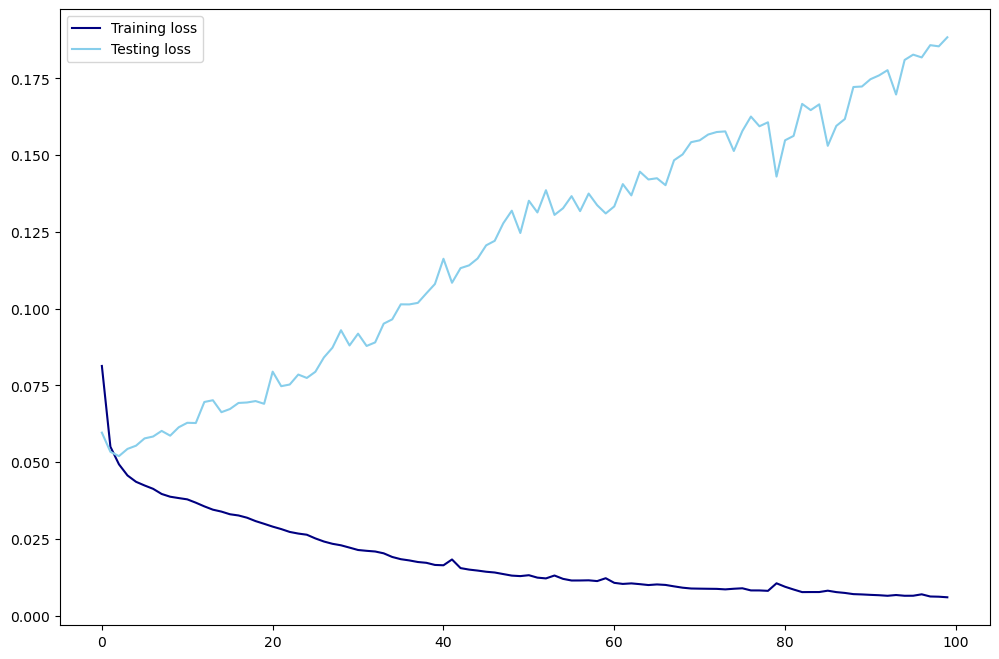

In [62]:
train_loss = history_first.history['loss']
test_loss = history_first.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

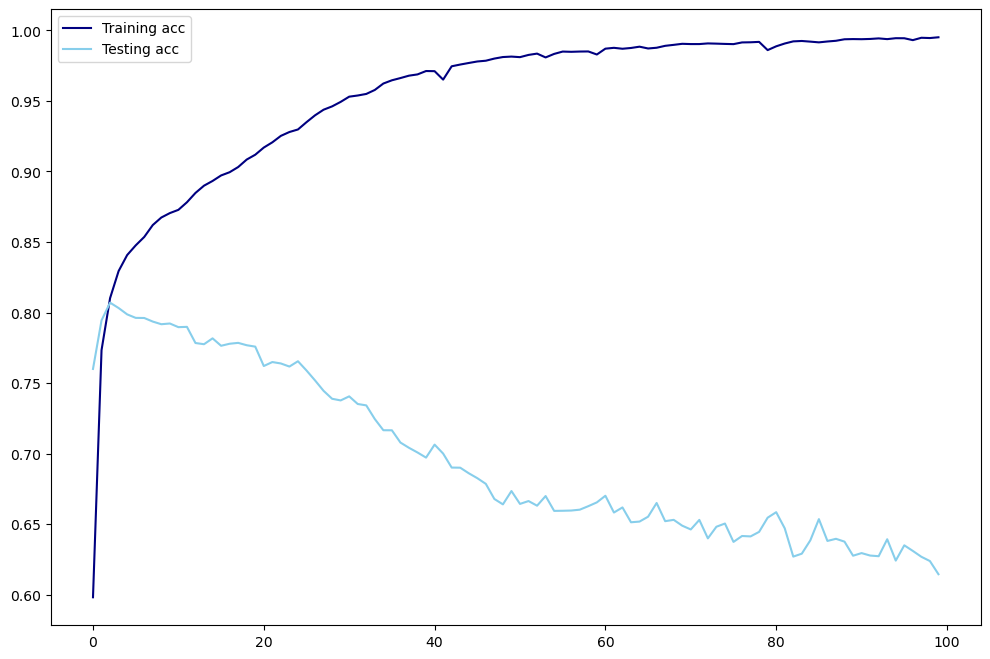

In [64]:
train_loss = history_first.history['prc']
test_loss = history_first.history['val_prc']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training acc', color='navy')
plt.plot(test_loss, label='Testing acc', color='skyblue')
plt.legend();

# Model with class weights

In [25]:
def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
    """
    Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
    Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
    The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
    of appareance of the label when the dataset was processed.
    In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
    Author: Angel Igareta (angel@igareta.com)
    """
    if multi_class:
        # If class is one hot encoded, transform to categorical labels to use compute_class_weight
        if one_hot_encoded:
            class_series = np.argmax(class_series, axis=1)

        # Compute class weights with sklearn method
        class_labels = np.unique(class_series)
        class_weights = compute_class_weight(
            class_weight="balanced", classes=class_labels, y=class_series
        )
        return dict(zip(class_labels, class_weights))
    else:
        # It is neccessary that the multi-label values are one-hot encoded
        mlb = None
        if not one_hot_encoded:
            mlb = MultiLabelBinarizer()
            class_series = mlb.fit_transform(class_series)

        n_samples = len(class_series)
        n_classes = len(class_series[0])

        # Count each class frequency
        class_count = [0] * n_classes
        for classes in class_series:
            for index in range(n_classes):
                if classes[index] != 0:
                    class_count[index] += 1

        # Compute class weights using balanced method
        class_weights = [
            n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count
        ]
        class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
        return dict(zip(class_labels, class_weights))

In [26]:
class_weights = generate_class_weights(y_train, multi_class=False, one_hot_encoded=True)

In [27]:
log_dir2 = "logs/fit/model_class_weights" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir2, histogram_freq=1)

In [42]:
EPOCHS = 100

history = model.fit(vectorized_X_train, y_train, epochs=EPOCHS, validation_data=(vectorized_X_test, y_test), batch_size=32, verbose=1, callbacks=[tensorboard_callback], class_weight=class_weights)

Epoch 1/100
3491/3491 [==============================] - 47s 13ms/step - loss: 0.0660 - tp: 19989.0000 - fp: 3291.0000 - tn: 642338.0000 - fn: 4576.0000 - accuracy: 0.9883 - precision: 0.8586 - recall: 0.8137 - auc: 0.9913 - prc: 0.9130 - val_loss: 0.0713 - val_tp: 6730.0000 - val_fp: 2158.0000 - val_tn: 274541.0000 - val_fn: 3803.0000 - val_accuracy: 0.9792 - val_precision: 0.7572 - val_recall: 0.6389 - val_auc: 0.9505 - val_prc: 0.7510
Epoch 2/100
3491/3491 [==============================] - 46s 13ms/step - loss: 0.0452 - tp: 21342.0000 - fp: 2403.0000 - tn: 643226.0000 - fn: 3223.0000 - accuracy: 0.9916 - precision: 0.8988 - recall: 0.8688 - auc: 0.9951 - prc: 0.9513 - val_loss: 0.0788 - val_tp: 7127.0000 - val_fp: 2656.0000 - val_tn: 274043.0000 - val_fn: 3406.0000 - val_accuracy: 0.9789 - val_precision: 0.7285 - val_recall: 0.6766 - val_auc: 0.9440 - val_prc: 0.7433
Epoch 3/100
3491/3491 [==============================] - 46s 13ms/step - loss: 0.0407 - tp: 21667.0000 - fp: 2201.00

In [43]:
%tensorboard --logdir logs/fit/model_class_weights

In [24]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

NameError: name 'history' is not defined

## Model with early stopping

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [20]:
EPOCHS = 100
history_stop = model.fit(vectorized_X_train, y_train, epochs=EPOCHS, validation_data=(vectorized_X_test, y_test), batch_size=32, verbose=1, class_weight=class_weights, callbacks=[early_stopping])

Epoch 1/100


2022-10-13 14:08:02.863263: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


3491/3491 [==============================] - 48s 13ms/step - loss: 0.1465 - tp: 12606.0000 - fp: 3610.0000 - tn: 642020.0000 - fn: 11958.0000 - accuracy: 0.9768 - precision: 0.7774 - recall: 0.5132 - auc: 0.9544 - prc: 0.6836 - val_loss: 0.0506 - val_tp: 6252.0000 - val_fp: 1038.0000 - val_tn: 275660.0000 - val_fn: 4282.0000 - val_accuracy: 0.9815 - val_precision: 0.8576 - val_recall: 0.5935 - val_auc: 0.9806 - val_prc: 0.8142
Epoch 2/100
3491/3491 [==============================] - 44s 12ms/step - loss: 0.1042 - tp: 15833.0000 - fp: 3326.0000 - tn: 642304.0000 - fn: 8731.0000 - accuracy: 0.9820 - precision: 0.8264 - recall: 0.6446 - auc: 0.9807 - prc: 0.8152 - val_loss: 0.0509 - val_tp: 6396.0000 - val_fp: 1100.0000 - val_tn: 275598.0000 - val_fn: 4138.0000 - val_accuracy: 0.9818 - val_precision: 0.8533 - val_recall: 0.6072 - val_auc: 0.9752 - val_prc: 0.8136
Epoch 3/100
3491/3491 [==============================] - 44s 13ms/step - loss: 0.0923 - tp: 16468.0000 - fp: 3137.0000 - tn: 64

In [21]:
model.save(os.path.join('model1_saved_file', 'model_with_early_stopping.h5'))

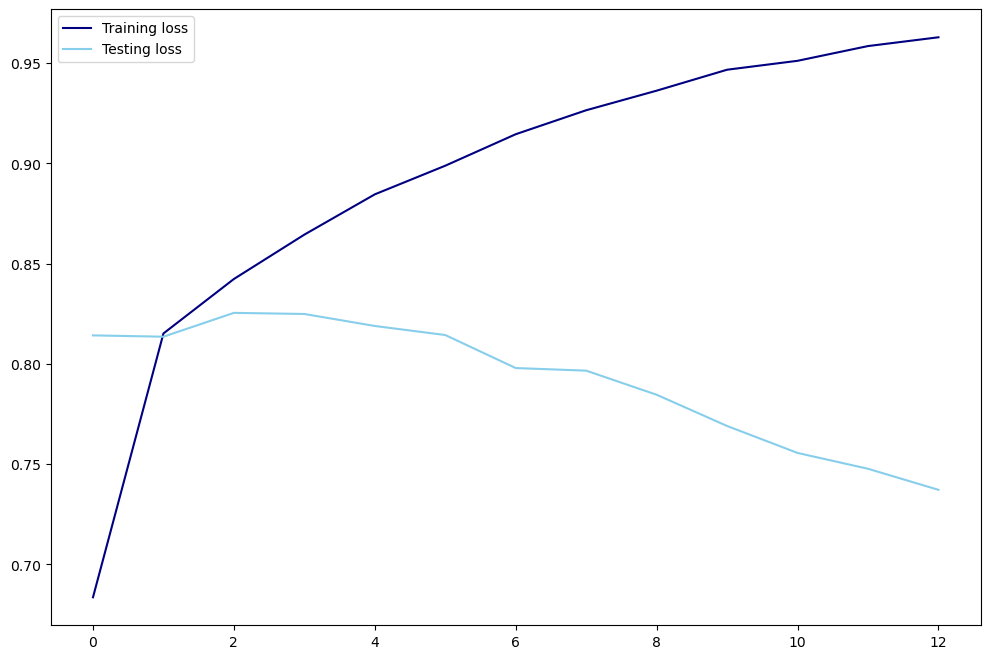

In [22]:
train_loss = history_stop.history['prc']
test_loss = history_stop.history['val_prc']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

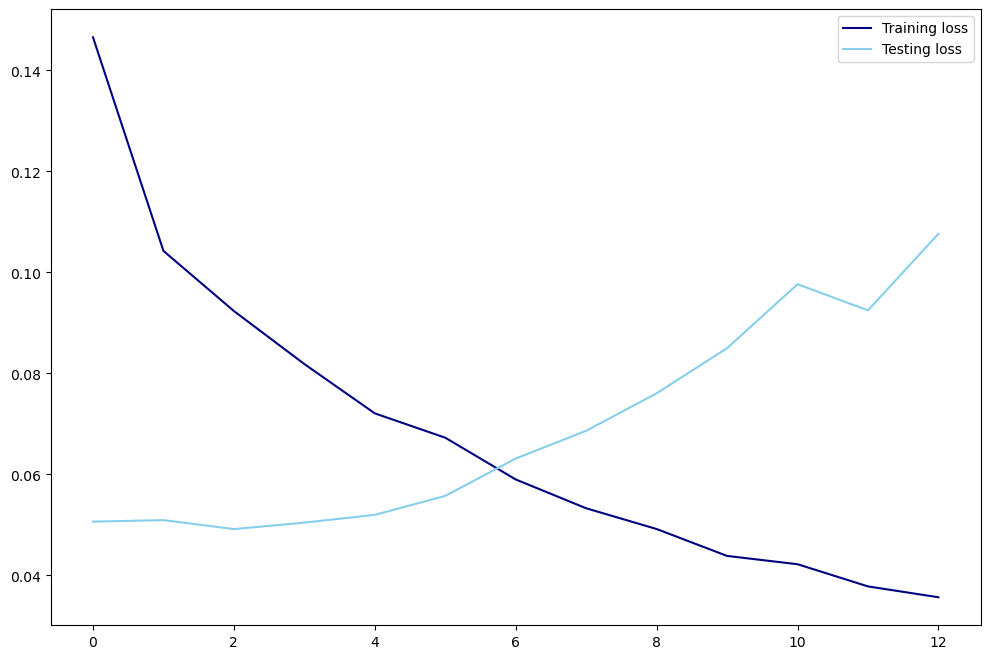

In [23]:
train_loss = history_stop.history['loss']
test_loss = history_stop.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

In [113]:
train_predictions_baseline = model.predict(vectorized_X_train, batch_size=32)
test_predictions_baseline = model.predict(vectorized_X_test, batch_size=32)

1496/1496 [==============================] - 6s 4ms/step


In [66]:
# def plot_cm(labels, predictions, p=0.5):
#     cm = confusion_matrix(labels, predictions > p)
#     plt.figure(figsize=(5,5))
#     sns.heatmap(cm, annot=True, fmt="d")
#     plt.title('Confusion matrix @{:.2f}'.format(p))
#     plt.ylabel('Actual label')
#     plt.xlabel('Predicted label')

#     print('True Negatives: ', cm[0][0])
#     print('False Positives: ', cm[0][1])
#     print('False Negatives: ', cm[1][0])
#     print('True Positives: ', cm[1][1])
#     print('Total: ', np.sum(cm[1]))


In [114]:
cm = multilabel_confusion_matrix(y_test, test_predictions_baseline > 0.5)
# plt.figure(figsize=(5,5))
# sns.heatmap(cm, annot=True, fmt="d")
# plt.title('Confusion matrix @{:.2f}'.format(p))
# plt.ylabel('Actual label')
# plt.xlabel('Predicted label')
cm

array([[[42483,   801],
        [ 1277,  3311]],

       [[47296,    98],
        [  351,   127]],

       [[44772,   565],
        [  529,  2006]],

       [[47660,    69],
        [  100,    43]],

       [[44797,   712],
        [  759,  1604]],

       [[47267,   179],
        [  240,   186]]])

In [114]:
from tensorflow import keras
model = keras.models.load_model("./model1_saved_file/model_x_train_ep5.h5")

In [119]:
model.evaluate(vectorized_X_test, y_test)

1496/1496 [==============================] - 7s 4ms/step - loss: 0.0523 - accuracy: 0.9804


[0.052330248057842255, 0.9803851842880249]

In [112]:
# batch = test.as_numpy_iterator().next()

In [115]:
# model.predict(np.expand_dims(input_text,0))

In [116]:
from tensorflow.keras.metrics import Precision, Recall, AUC, CategoricalAccuracy, Accuracy

In [117]:
pre = Precision()
rec = Recall()
acc = Accuracy()

In [118]:
# for batch in test.as_numpy_iterator():
#     X_true, y_true = batch
#     yhat = model.predict(X_true)

#     y_true = y_true.flatten()
#     yhat = yhat.flatten()

#     pre.update_state(y_true, yhat)
#     rec.update_state(y_true, yhat)
#     acc.update_state(y_true, yhat)

In [ ]:
y_pred = model.predict(vectorized_X_test)


In [149]:
print(f'Precision: {pre.result().numpy()}, Recall:{rec.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.8293979167938232, Recall:0.7679348587989807, Accuracy: 0.0


In [25]:
pred_model = keras.models.load_model("./model1_saved_file/model_less_length_dropout_reduced_layers_ep3.h5")

In [26]:
actual_test = pd.read_csv('../data/test.csv')

In [154]:
max_features = 20000
vectorizer = TextVectorization(max_tokens=max_features, output_mode='int', output_sequence_length=100)

# vectorizer.adapt(actual_test['comment_text'], batch_size=16)

In [27]:
vectorized_text = vectorizer(actual_test['comment_text'])

In [32]:
vectorized_text

<tf.Tensor: shape=(153164, 200), dtype=int64, numpy=
array([[ 2661,   762, 10794, ...,     0,     0,     0],
       [   31,  1246,     2, ...,     0,     0,     0],
       [  107,     1,     1, ...,     0,     0,     0],
       ...,
       [    1,  1212,     8, ...,     0,     0,     0],
       [   50,     4,     2, ...,     0,     0,     0],
       [  168,   226,    21, ...,     0,     0,     0]])>

In [31]:
test_res = model.predict(np.expand_dims(vectorized_text,0))

2022-10-11 14:39:13.896104: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 14.61GiB (rounded to 15683993600)requested by op sequential/embedding/embedding_lookup
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-10-11 14:39:13.896130: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] BFCAllocator dump for GPU_0_bfc
2022-10-11 14:39:13.896138: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (256): 	Total Chunks: 54, Chunks in use: 53. 13.5KiB allocated for chunks. 13.2KiB in use in bin. 1.1KiB client-requested in use in bin.
2022-10-11 14:39:13.896144: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (512): 	Total Chunks: 3, Chunks in use: 3. 1.5KiB allocated for chunks. 1.5KiB in use in bin. 1.5KiB client-requested in use in bin.
202

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/embedding/embedding_lookup' defined at (most recent call last):
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_29129/2877429457.py", line 1, in <cell line: 1>
      test_res = model.predict(np.expand_dims(vectorized_text,0))
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1983, in predict_step
      return self(x, training=False)
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/keras/layers/core/embedding.py", line 208, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential/embedding/embedding_lookup'
OOM when allocating tensor with shape[1,153164,200,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/embedding/embedding_lookup}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_14708]

In [30]:
test_res

array([[0.49265477, 0.49556106, 0.500393  , 0.48955858, 0.50027287,
        0.5010112 ]], dtype=float32)